In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-v0_8-dark')

In [31]:
import pandas as pd

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import QuantileTransformer, StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xg

from sklearn import metrics

In [3]:
data = pd.read_csv('hail-2015.csv', index_col = 'X.ZTIME', nrows = 3000000)
data.head()

,LON,LAT,WSR_ID,CELL_ID,RANGE,AZIMUTH,SEVPROB,PROB,MAXSIZE
X.ZTIME,,,,,,,,,
2.015010e+13,-97.16003,32.66308,KDFW,C0,27,207,0,10,0.5
2.015010e+13,-97.01849,32.57796,KDAL,E0,21,187,0,50,0.5
2.015010e+13,-97.01735,32.58810,KDFW,J0,29,190,0,20,0.5
2.015010e+13,-96.99553,32.59287,KDAL,E0,20,184,0,40,0.5
2.015010e+13,-96.96180,32.62550,KDAL,E0,18,179,0,30,0.5


In [4]:
data.shape

(3000000, 9)

In [5]:
data.index = (pd.to_datetime(pd.Series(range(len(data))), unit = 's') - pd.to_datetime('1970-01-01'))
data.head()

,LON,LAT,WSR_ID,CELL_ID,RANGE,AZIMUTH,SEVPROB,PROB,MAXSIZE
0 days 00:00:00,-97.16003,32.66308,KDFW,C0,27,207,0,10,0.5
0 days 00:00:01,-97.01849,32.57796,KDAL,E0,21,187,0,50,0.5
0 days 00:00:02,-97.01735,32.58810,KDFW,J0,29,190,0,20,0.5
0 days 00:00:03,-96.99553,32.59287,KDAL,E0,20,184,0,40,0.5
0 days 00:00:04,-96.96180,32.62550,KDAL,E0,18,179,0,30,0.5


In [6]:
data.tail()

,LON,LAT,WSR_ID,CELL_ID,RANGE,AZIMUTH,SEVPROB,PROB,MAXSIZE
34 days 17:19:55,-87.68603,32.39541,KDGX,H2,117,86,0,50,0.5
34 days 17:19:56,-151.00143,62.06162,PAHG,X0,81,7,0,10,0.5
34 days 17:19:57,-149.64359,60.87691,PAHG,V0,51,79,0,30,0.5
34 days 17:19:58,-81.86136,32.76381,KFFC,N0,141,104,-999,-999,-999.0
34 days 17:19:59,-82.77544,35.23177,KFFC,W6,143,38,-999,-999,-999.0


In [7]:
data[data.columns[-3:]] = data[data.columns[-3:]].replace({-999 : 0})

'''
we'll get rid of the equipment and storm ID fetures because the only way they may
hold usufull information is via their location, which we already have
'''

data.drop(['CELL_ID', 'WSR_ID'], axis = 1, inplace = True)

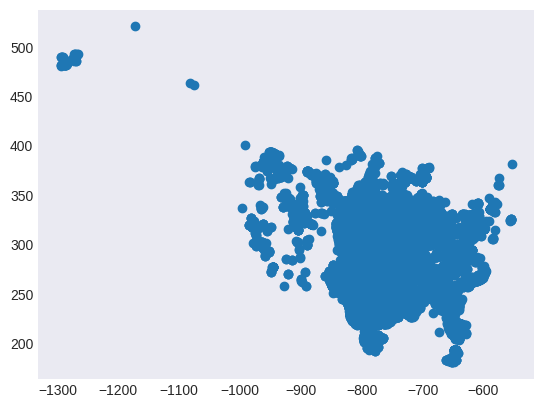

In [8]:
severe_data = data[data['SEVPROB'] >= 80] * 8

plt.scatter(severe_data['LON'], severe_data['LAT'])
plt.show()

In [9]:
''' avraging over every 60 time stamps '''

data = data.resample('T').mean()
data.head()

,LON,LAT,RANGE,AZIMUTH,SEVPROB,PROB,MAXSIZE
0 days 00:00:00,-98.418219,31.068868,48.216667,196.633333,0.166667,40.666667,0.491667
0 days 00:01:00,-96.961912,32.544097,28.466667,172.550000,0.500000,33.000000,0.483333
0 days 00:02:00,-96.886162,32.836266,17.416667,173.150000,0.500000,26.833333,0.500000
0 days 00:03:00,-97.020589,32.899137,21.250000,215.716667,0.000000,26.833333,0.500000
0 days 00:04:00,-97.023409,33.054803,15.333333,219.350000,0.000000,23.333333,0.500000


In [10]:
''' we r interested in predicting the probabilty of a severe wether event'''

data, target = data.drop('SEVPROB', axis = 1), data['SEVPROB']

data.shape, target.shape

((50000, 6), (50000,))

In [11]:
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size = 0.15, random_state = 3)

train_data.shape, test_data.shape, train_target.shape, test_target.shape

((42500, 6), (7500, 6), (42500,), (7500,))

#### Applying the ML models

In [39]:
# for the metric sensetive models we use the more rubost: Quntile Scaler

knn_pipe = Pipeline([('scale', QuantileTransformer()),
                     ('model', KNeighborsRegressor())])

knn = GridSearchCV(estimator = knn_pipe, cv = 3, param_grid = {'model__n_jobs' : [5, 7, 9], 'model__p' : [1, 2]})

svm = Pipeline([('scale', StandardScaler()),
                ('model', SVR())])

adaboost_pipe = Pipeline([('scale', QuantileTransformer()),
                          ('mpdel', AdaBoostRegressor())])

adaboost = GridSearchCV(estimator = adaboost_pipe, cv = 3, param_grid = {'mpdel__estimator': [None, DecisionTreeRegressor()], 'mpdel__n_estimators' : [100, 200]})

forest_pipe = Pipeline([('scale', StandardScaler()),
                        ('model', RandomForestRegressor())])

random_forest = GridSearchCV(estimator = forest_pipe, cv = 3, param_grid = {'model__n_estimators' : [100, 200], 'model__min_samples_leaf' : [10, 30, 50]})

# model evaluation
def print_metric(pred): print(f'MSE: {metrics.mean_absolute_error(test_target, pred)}\nR2: {metrics.r2_score(test_target, pred)}')

In [16]:
knn.fit(train_data, train_target)
print_metric(knn.predict(test_data))

MSE: 2.1995244444444446
R2: 0.6883292651390556


In [18]:
svm.fit(train_data, train_target)
print_metric(svm.predict(test_data))

MSE: 2.00786181981234
R2: 0.7205043296672429


In [21]:
adaboost.fit(train_data, train_target)
print_metric(adaboost.predict(test_data))

MSE: 1.9986666666666666
R2: 0.7415568196767974


In [30]:
random_forest.fit(train_data, train_target)
print_metric(random_forest.predict(test_data))

MSE: 2.0279857089928246
R2: 0.7368698972235276


In [34]:
gradient_boost = xg.XGBRegressor(n_estimators = 200)
gradient_boost.fit(train_data, train_target)
print_metric(gradient_boost.predict(test_data))

MSE: 2.0065715579313457
R2: 0.7493931652955472


#### trying out adding multlipications of the fetures in advance

In [40]:
knn_pipe.steps.insert(0, ('preprocessor', PolynomialFeatures()))

knn.fit(train_data, train_target)
print_metric(knn.predict(test_data))

MSE: 2.1481822222222227
R2: 0.7029257152086313


In [42]:
svm = Pipeline([('preprocessor', PolynomialFeatures()),
                 ('model', SVR())])

svm.fit(train_data, train_target)
print_metric(svm.predict(test_data))

MSE: 2.6116159247526425
R2: 0.5466341141898838


In [45]:
gradient_boost = Pipeline([('preprocessor', PolynomialFeatures()),
                           ('model', xg.XGBRegressor())])

gradient_boost.fit(train_data, train_target)
print_metric(gradient_boost.predict(test_data))

MSE: 1.9912936240084105
R2: 0.7505735674713785


#### harder challange: anticipate the future

In [19]:
''' reshaping the data so that the challange is: given 5 minutes of record predict the next 3 '''

stacked_data = {col : pd.DataFrame(zip( * (list(data[col])[i:] for i in range(5))))  for col in data.columns}
stacked_target = pd.DataFrame(zip( * (list(target)[5 + i:] for i in range(3))))

data, target = pd.concat(stacked_data, axis = 1)[:-3], stacked_target

data.head()

LON                                                    LAT  \
           0          1          2          3          4          0   
0 -98.418219 -96.961912 -96.886162 -97.020589 -97.023409  31.068868   
1 -96.961912 -96.886162 -97.020589 -97.023409 -96.474173  32.544097   
2 -96.886162 -97.020589 -97.023409 -96.474173 -94.576301  32.836266   
3 -97.020589 -97.023409 -96.474173 -94.576301 -92.795223  32.899137   
4 -97.023409 -96.474173 -94.576301 -92.795223 -94.862745  33.054803   

                                               ...       PROB             \
           1          2          3          4  ...          0          1   
0  32.544097  32.836266  32.899137  33.054803  ...  40.666667  33.000000   
1  32.836266  32.899137  33.054803  32.766937  ...  33.000000  26.833333   
2  32.899137  33.054803  32.766937  32.490277  ...  26.833333  26.833333   
3  33.054803  32.766937  32.490277  33.013986  ...  26.833333  23.333333   
4  32.766937  32.490277  33.013986  33.045726  ...  23.333333  36.000000   

                                     MAXSIZE                                \
           2          3          4         0         1         2         3   
0  26.833333  26.833333  23.333333  0.491667  0.483333  0.500000  0.500000   
1  26.833333  23.333333  36.000000  0.483333  0.500000  0.500000  0.500000   
2  23.333333  36.000000  24.166667  0.500000  0.500000  0.500000  0.500000   
3  36.000000  24.166667  17.666667  0.500000  0.500000  0.500000  0.333333   
4  24.166667  17.666667  25.500000  0.500000  0.500000  0.333333  0.241667   

             
          4  
0  0.500000  
1  0.500000  
2  0.333333  
3  0.241667  
4  0.408333  

[5 rows x 30 columns]

In [20]:
data.shape, target.shape

((49993, 30), (49993, 3))

In [21]:
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size = 0.15, random_state = 3)

train_data.shape, test_data.shape, train_target.shape, test_target.shape

((42494, 30), (7499, 30), (42494, 3), (7499, 3))

In [22]:
knn.fit(train_data, train_target)
print_metric(knn.predict(test_data))

MSE: 2.842885718095751
R2: 0.4726678517365002
